<a href="https://colab.research.google.com/github/Ashay-20/Kaggle/blob/main/traffic_congestion_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost import XGBRegressor
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


In [ ]:
df=pd.read_csv("../input/tabular-playground-series-mar-2022/train.csv")
test=pd.read_csv("../input/tabular-playground-series-mar-2022/test.csv")
sub=pd.read_csv("../input/tabular-playground-series-mar-2022/sample_submission.csv")


# Reduce Memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)  
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
reduce_mem_usage(df)
reduce_mem_usage(test)

Mem. usage decreased to  8.70 Mb (77.6% reduction)
Mem. usage decreased to  0.02 Mb (78.1% reduction)


,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB
...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB
2336,851171,1991-09-30 23:40:00,2,3,NE
2337,851172,1991-09-30 23:40:00,2,3,SB
2338,851173,1991-09-30 23:40:00,2,3,SW


# Adding Date Time features

In [ ]:
def features_new(df,cl):
    df[cl] = pd.to_datetime(df[cl])
    df["month"]=df.time.dt.month
    df["day"]=df.time.dt.day
    df["hour"]=df.time.dt.hour+(df.time.dt.minute)/60
    df["weekday"]=df.time.dt.weekday
    df["day of year"]=df.time.dt.dayofyear
features_new(df,'time')
features_new(test,'time')

# Adding weekend ⛪🏡 *Saturday* and *Sunday* as features

In [ ]:

df['sunday'] = np.where(df['weekday']==6,1, 0)
df['saturday'] = np.where(df['weekday']==5,1, 0)

test['sunday'] = np.where(test['weekday']==6,1, 0)
test['saturday'] = np.where(test['weekday']==5,1, 0)


# Plotting Bar chart for congestion🚗🚙🚔
* It can be observed from plot that some values have higher congestion than their neighbouring values.
    * Values with traffic **🚗🚗🚙** **congestion=15,20,21,29,34** has much higher count than its neighbours.    

Text(0.5, 0, 'Congestion')

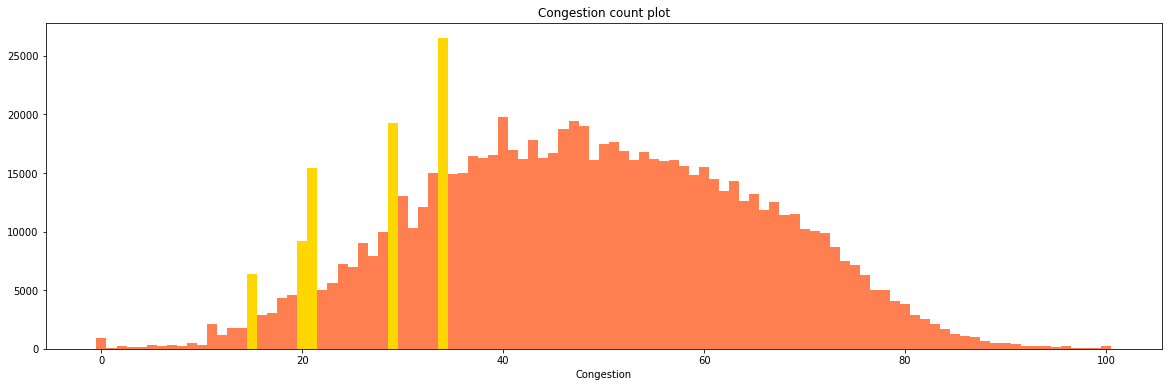

In [ ]:
plt.figure(figsize=(20, 6))
plt.bar(range(101), df.congestion.value_counts().sort_index(), width=1,
        color=['gold' if con in [15, 20, 21, 29, 34] else 'coral' for con in range(101)])
plt.title("Congestion count plot")
plt.xlabel("Congestion")

# Dependence of congestion 🚗🚙 on time of day
* Maximum traffic congestion is at 5:00 P.M
* Minimum traffic congestion is at 4:00 A.M

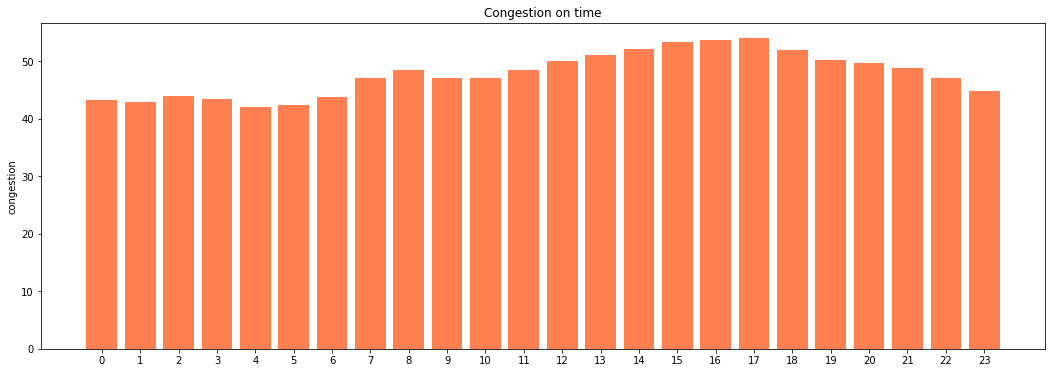

In [ ]:

plt.figure(figsize=(18, 6))
plt.bar(df.groupby(df.time.dt.hour).congestion.mean().index,df.groupby(df.time.dt.hour).congestion.mean(),color="coral")
plt.xticks(range(24))
plt.ylabel("congestion")
plt.title("Congestion on time")
plt.show()

# Traffic 🚗🚙 Congestion on Date

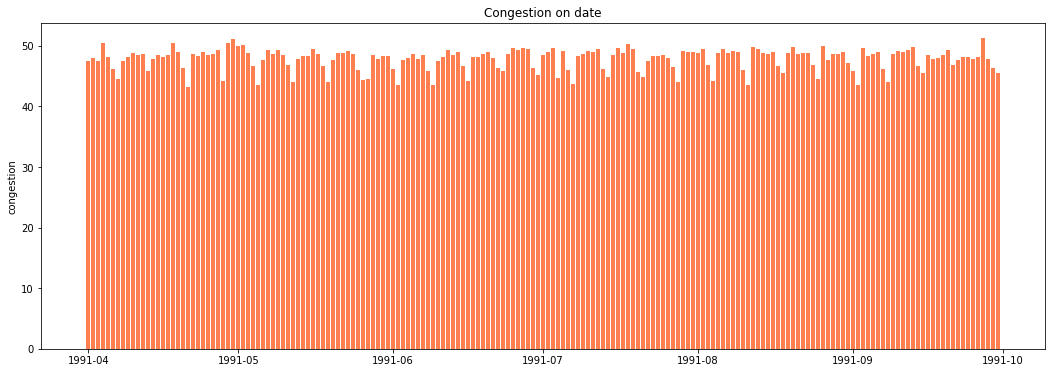

In [ ]:
plt.figure(figsize=(18, 6))
plt.bar(df.groupby(df.time.dt.date).congestion.mean().index,df.groupby(df.time.dt.date).congestion.mean(),color="coral")
plt.ylabel("congestion")
plt.title("Congestion on date")
plt.show()

# Traffic 🚗🚙 Congestion on day of week
* It is observed that congestion is less on weekend.

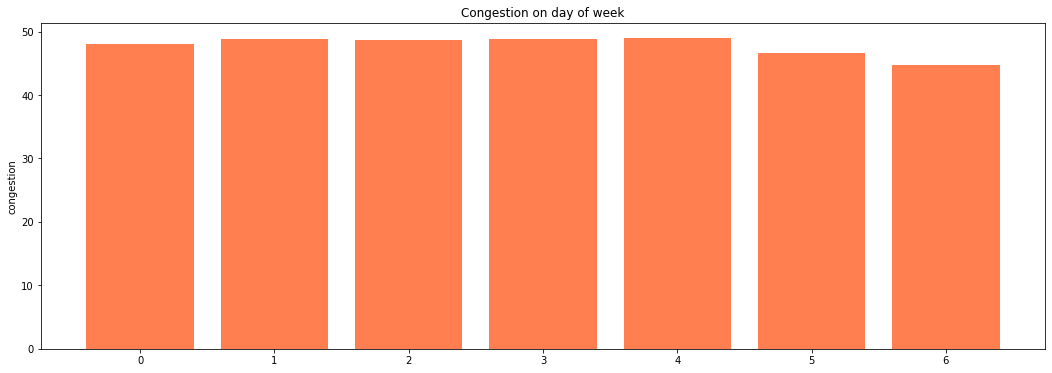

In [ ]:
plt.figure(figsize=(18, 6))
plt.bar(df.groupby(df.time.dt.dayofweek).congestion.mean().index,df.groupby(df.time.dt.dayofweek).congestion.mean(),color="coral")
plt.xticks(range(7))
plt.ylabel("congestion")
plt.title("Congestion on day of week")
plt.show()

# One Hot Encoding direction column

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat=["direction"]
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
train = pd.DataFrame(OH_encoder.fit_transform(df[cat]),columns=list(OH_encoder.get_feature_names()))
en_test = pd.DataFrame(OH_encoder.transform(test[cat]),columns=list(OH_encoder.get_feature_names()))
# One-hot encoding removed index; put it back
train.index = df.index
en_test.index = test.index
df=df.drop(cat,axis=1)
test=test.drop(cat,axis=1)
df=pd.concat([df,train],axis=1)
test=pd.concat([test,en_test],axis=1)

In [ ]:
feats=[col for col in df.columns if col not in ["row_id","congestion","direction","time"]]

# Optuna Hyper Parameter Tuning

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):

    param_grid = {
              'n_estimators': trial.suggest_int('n_estimators',256,2048),
              'learning_rate': trial.suggest_discrete_uniform('learning_rate',0.01,0.1,0.01),
              'subsample': trial.suggest_categorical ('subsample', [0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
              'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree',0.1,1.0, 0.1),
              'max_depth': trial.suggest_int('max_depth', 2, 20),
              'booster': 'gbtree',
              'gamma': trial.suggest_uniform('gamma',1.0,10.0),
              'reg_alpha': trial.suggest_int('reg_alpha',50,100),
              'reg_lambda': trial.suggest_int('reg_lambda',50,100),
              'random_state': 42,
              'enable_categorical': True
                 }
    x_train, x_valid, y_train, y_valid = train_test_split(df[feats], df.congestion, test_size=0.3, random_state=50)
    xgb_model = XGBRegressor(**param_grid, tree_method='gpu_hist', predictor='gpu_predictor')
    xgb_model.fit(x_train, y_train, verbose=False)
    y_pred = xgb_model.predict(x_valid)
    return mean_absolute_error(y_valid, y_pred)
    

train_time = 1 * 60 * 1 # h * m * s
study = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
study.optimize(objective, timeout=train_time)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('\tValue: {}'.format(trial.value))
print('\tParams: ')
for key, value in trial.params.items():
    print('\t\t{}: {}'.format(key, value))

[I 2022-03-02 09:38:22,651] A new study created in memory with name: XGBRegressor
[I 2022-03-02 09:38:35,285] Trial 0 finished with value: 6.403421401977539 and parameters: {'n_estimators': 1826, 'learning_rate': 0.09999999999999999, 'subsample': 0.3, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 7.673877464029853, 'reg_alpha': 91, 'reg_lambda': 56}. Best is trial 0 with value: 6.403421401977539.
[I 2022-03-02 09:39:08,532] Trial 1 finished with value: 6.779500484466553 and parameters: {'n_estimators': 299, 'learning_rate': 0.02, 'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 19, 'gamma': 6.298074027558028, 'reg_alpha': 52, 'reg_lambda': 77}. Best is trial 0 with value: 6.403421401977539.
[I 2022-03-02 09:39:10,446] Trial 2 finished with value: 11.730611801147461 and parameters: {'n_estimators': 308, 'learning_rate': 0.08, 'subsample': 0.9, 'colsample_bytree': 0.1, 'max_depth': 18, 'gamma': 6.62543920406061, 'reg_alpha': 89, 'reg_lambda': 89}. Best is trial 0 with value: 6

Number of finished trials:  6
Best trial:
	Value: 6.185979843139648
	Params: 
		n_estimators: 1724
		learning_rate: 0.06999999999999999
		subsample: 0.6
		colsample_bytree: 0.6
		max_depth: 8
		gamma: 7.8673359990082155
		reg_alpha: 68
		reg_lambda: 52


# XGBoost

In [ ]:
xgb_params = trial.params
xgb_params['tree_method'] = 'gpu_hist'
xgb_params['predictor'] = 'gpu_predictor'

reg = XGBRegressor(**xgb_params)
reg.fit(df[feats],df['congestion'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=7.8673359990082155, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.06999999999999999,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1724, n_jobs=2,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
             reg_alpha=68, reg_lambda=52, scale_pos_weight=1, subsample=0.6,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

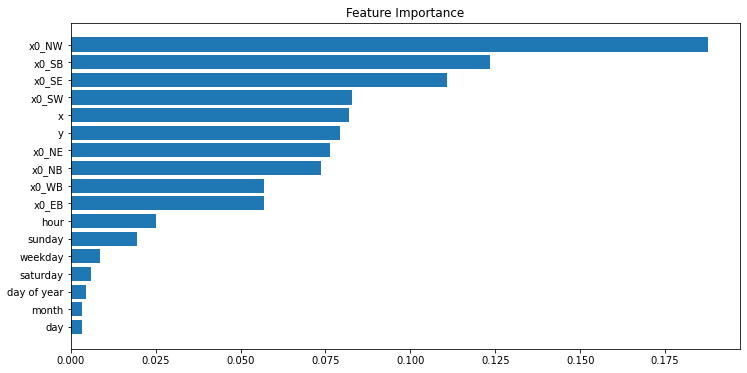

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df[feats].columns)[sorted_idx])
plt.title('Feature Importance')

# Predictions

In [ ]:
preds=reg.predict(test[feats])

In [ ]:
sub.congestion=preds
sub.to_csv("submission.csv",index=False)
